In [1]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data Preparataion

In [3]:

data_dir_train = "Data/Training"
data_dir_val = "Data/Validation"

target_size = (128,128)
epochs = 50

# Data Loading

In [4]:
def plot(data,grid,meta,classes=None):
    images = data[0]
    labels = data[1]
    plt.figure(figsize=(11,8))
    plt.title(meta)
    for i in range(len(images)):
        plt.subplot(grid[0],grid[1],i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        
        plt.xlabel(classes[np.argmax(labels[i])],fontsize=8)
    
    plt.tight_layout()
    

### Image Preprocessing

In [5]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                            rescale=1./255.0,
                                                            )
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.0)


train_data = train_gen.flow_from_directory(directory=data_dir_train,
                            target_size=target_size,
                            batch_size=2,       
                           )
val_data = val_gen.flow_from_directory(directory=data_dir_val,
                            target_size=target_size,
                            batch_size=1,
                        )


Found 4719 images belonging to 4 classes.
Found 1171 images belonging to 4 classes.


In [6]:
class_names = list(val_data.class_indices.keys())

### Sample Train Data

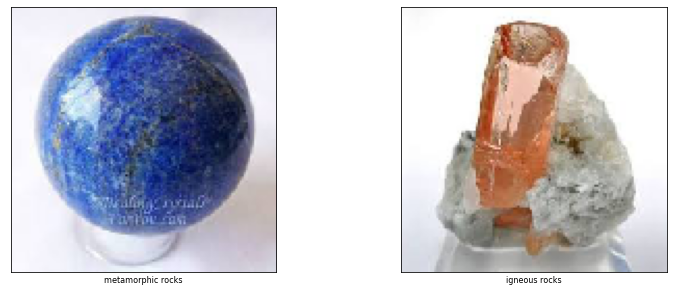

In [7]:
plot(train_data.next(),(2,2),"Train Data",class_names)

### Sample Validation Data

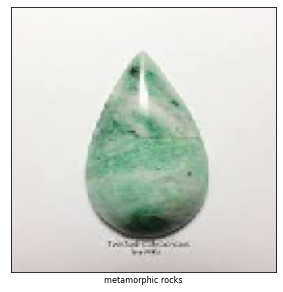

In [8]:
plot(val_data.next(),(2,2),"val Data",class_names)

# Model Comparison

## VGG19

In [9]:
vgg_19 = tf.keras.applications.vgg19.VGG19(include_top=False,weights=None,input_shape=(target_size[0],target_size[1],3))

model = tf.keras.models.Sequential()
model.add(vgg_19)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.layers[0].trainable=False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [11]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [12]:
history_vgg = model.fit(train_data,batch_size=8,validation_data=val_data,epochs=epochs)

Epoch 1/50
2360/2360 [==============================] - 100s 40ms/step - loss: 1.5330 - accuracy: 0.2346 - precision: 0.2231 - recall: 0.0364 - val_loss: 1.7809 - val_accuracy: 0.3254 - val_precision: 0.3254 - val_recall: 0.3254
Epoch 2/50
2360/2360 [==============================] - 91s 38ms/step - loss: 1.4161 - accuracy: 0.2587 - precision: 0.5909 - recall: 0.0028 - val_loss: 1.3846 - val_accuracy: 0.2485 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2360/2360 [==============================] - 91s 39ms/step - loss: 1.4009 - accuracy: 0.2590 - precision: 0.5000 - recall: 2.1191e-04 - val_loss: 1.9213 - val_accuracy: 0.3305 - val_precision: 0.3312 - val_recall: 0.3151
Epoch 4/50
2360/2360 [==============================] - 97s 41ms/step - loss: 1.3968 - accuracy: 0.2570 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3692 - val_accuracy: 0.3245 - val_precision: 1.0000 - val_recall: 8.5397e-04
Epoch 5/50
2360/2360 [==============================] - 93s 40m

## Custom Architechtre

In [13]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(target_size[0],target_size[1],3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu',input_dim=128))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

In [14]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [15]:
history_conv = model.fit(train_data,batch_size=4,validation_data=val_data,epochs=epochs)

Epoch 1/50
2360/2360 [==============================] - 80s 30ms/step - loss: 1.5225 - accuracy: 0.2554 - precision_1: 0.2636 - recall_1: 0.0481 - val_loss: 1.4748 - val_accuracy: 0.2929 - val_precision_1: 0.2673 - val_recall_1: 0.0760
Epoch 2/50
2360/2360 [==============================] - 70s 30ms/step - loss: 1.4165 - accuracy: 0.2640 - precision_1: 0.2597 - recall_1: 0.0042 - val_loss: 1.4618 - val_accuracy: 0.3510 - val_precision_1: 0.4217 - val_recall_1: 0.1657
Epoch 3/50
2360/2360 [==============================] - 77s 32ms/step - loss: 1.4051 - accuracy: 0.2643 - precision_1: 0.4091 - recall_1: 0.0019 - val_loss: 1.5240 - val_accuracy: 0.3151 - val_precision_1: 0.3555 - val_recall_1: 0.1597
Epoch 4/50
2360/2360 [==============================] - 68s 29ms/step - loss: 1.4016 - accuracy: 0.2666 - precision_1: 0.5000 - recall_1: 2.1191e-04 - val_loss: 1.5473 - val_accuracy: 0.2536 - val_precision_1: 0.2405 - val_recall_1: 0.0760
Epoch 5/50
2360/2360 [==============================

## Inception V3

In [16]:
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(target_size[0],target_size[1],3))


model = tf.keras.models.Sequential()
model.add(inception)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.layers[0].trainable=False

In [17]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [18]:
history_inception = model.fit(train_data,batch_size=4,validation_data=val_data,epochs=epochs)

Epoch 1/50
2360/2360 [==============================] - 137s 56ms/step - loss: 1.4594 - accuracy: 0.3032 - precision_2: 0.3333 - recall_2: 0.0843 - val_loss: 1.7715 - val_accuracy: 0.4193 - val_precision_2: 0.4244 - val_recall_2: 0.3595
Epoch 2/50
2360/2360 [==============================] - 166s 70ms/step - loss: 1.3712 - accuracy: 0.3316 - precision_2: 0.3796 - recall_2: 0.0348 - val_loss: 1.6079 - val_accuracy: 0.4313 - val_precision_2: 0.4361 - val_recall_2: 0.3527
Epoch 3/50
2360/2360 [==============================] - 140s 59ms/step - loss: 1.3445 - accuracy: 0.3469 - precision_2: 0.4696 - recall_2: 0.0360 - val_loss: 1.6962 - val_accuracy: 0.4441 - val_precision_2: 0.4692 - val_recall_2: 0.4031
Epoch 4/50
2360/2360 [==============================] - 140s 59ms/step - loss: 1.3421 - accuracy: 0.3554 - precision_2: 0.4300 - recall_2: 0.0267 - val_loss: 1.8362 - val_accuracy: 0.4509 - val_precision_2: 0.4667 - val_recall_2: 0.4193
Epoch 5/50
2360/2360 [==============================

### SWIN Transformers

In [19]:
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
num_classes = len(class_names)
input_shape = (target_size[0],target_size[1], 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 128  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [21]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [22]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [23]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [24]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [25]:
input = layers.Input(input_shape)
#x = layers.RandomCrop(image_dimension, image_dimension)(input)
#x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(input)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [26]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],
)

history_swin = model.fit(
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_data,
)

Epoch 1/50
2360/2360 [==============================] - 223s 93ms/step - loss: 1.4485 - accuracy: 0.2734 - precision_3: 0.3045 - recall_3: 0.0284 - val_loss: 1.3686 - val_accuracy: 0.2775 - val_precision_3: 0.4857 - val_recall_3: 0.0145
Epoch 2/50
2360/2360 [==============================] - 216s 92ms/step - loss: 1.3647 - accuracy: 0.3213 - precision_3: 0.5217 - recall_3: 0.0178 - val_loss: 1.3553 - val_accuracy: 0.2878 - val_precision_3: 0.7750 - val_recall_3: 0.0265
Epoch 3/50
2360/2360 [==============================] - 216s 92ms/step - loss: 1.3391 - accuracy: 0.3541 - precision_3: 0.5804 - recall_3: 0.0314 - val_loss: 1.3794 - val_accuracy: 0.2852 - val_precision_3: 1.0000 - val_recall_3: 0.0026
Epoch 4/50
2360/2360 [==============================] - 217s 92ms/step - loss: 1.3179 - accuracy: 0.3808 - precision_3: 0.6189 - recall_3: 0.0513 - val_loss: 1.3286 - val_accuracy: 0.3459 - val_precision_3: 0.5315 - val_recall_3: 0.0649
Epoch 5/50
2360/2360 [==============================

##  Model Comparisons

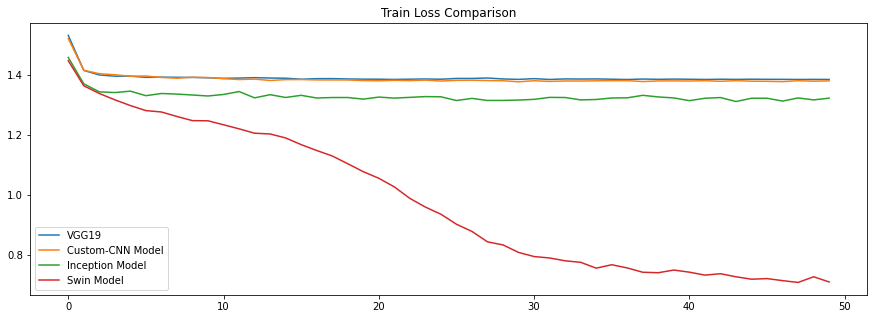

In [27]:
plt.figure(figsize=(15,5))
plt.title("Train Loss Comparison")
plt.plot(history_vgg.history["loss"],label="VGG19")
plt.plot(history_conv.history["loss"],label="Custom-CNN Model")
plt.plot(history_inception.history["loss"],label="Inception Model")
plt.plot(history_swin.history["loss"],label="Swin Model")

plt.legend()
plt.show()

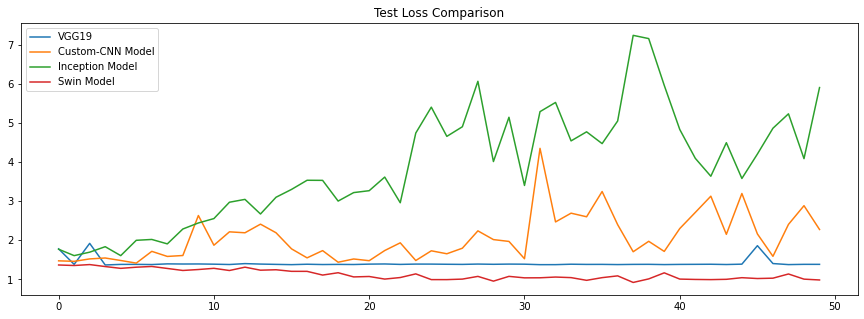

In [28]:
plt.figure(figsize=(15,5))
plt.title("Test Loss Comparison")
plt.plot(history_vgg.history["val_loss"],label="VGG19")
plt.plot(history_conv.history["val_loss"],label="Custom-CNN Model")
plt.plot(history_inception.history["val_loss"],label="Inception Model")
plt.plot(history_swin.history["val_loss"],label="Swin Model")
plt.legend()
plt.show()

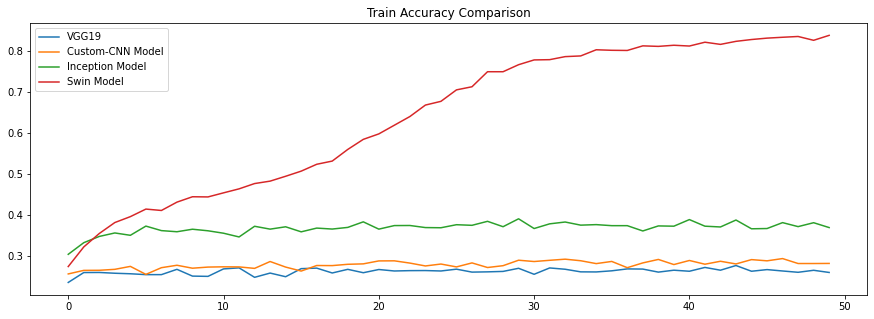

In [29]:
plt.figure(figsize=(15,5))
plt.title("Train Accuracy Comparison")
plt.plot(history_vgg.history["accuracy"],label="VGG19")
plt.plot(history_conv.history["accuracy"],label="Custom-CNN Model")
plt.plot(history_inception.history["accuracy"],label="Inception Model")
plt.plot(history_swin.history["accuracy"],label="Swin Model")

plt.legend()
plt.show()

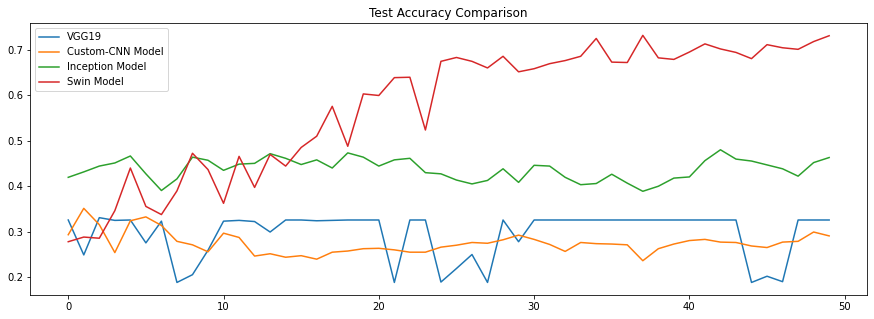

In [30]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_vgg.history["val_accuracy"],label="VGG19")
plt.plot(history_conv.history["val_accuracy"],label="Custom-CNN Model")
plt.plot(history_inception.history["val_accuracy"],label="Inception Model")
plt.plot(history_swin.history["val_accuracy"],label="Swin Model")
plt.legend()
plt.show()

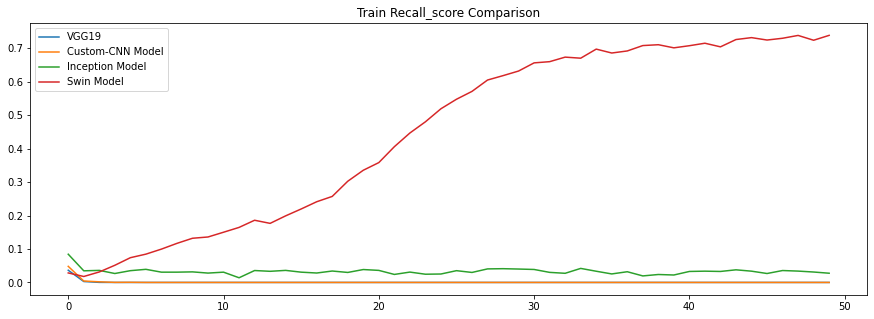

In [31]:
plt.figure(figsize=(15,5))
plt.title("Train Recall_score Comparison")
plt.plot(history_vgg.history["recall"],label="VGG19")
plt.plot(history_conv.history["recall_1"],label="Custom-CNN Model")
plt.plot(history_inception.history["recall_2"],label="Inception Model")
plt.plot(history_swin.history["recall_3"],label="Swin Model")
plt.legend()
plt.show()

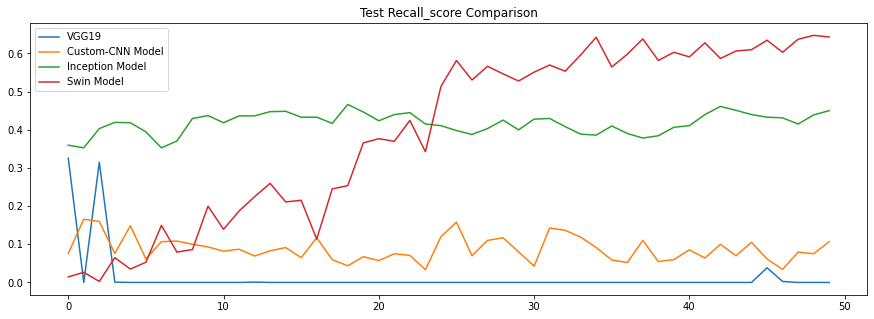

In [32]:
plt.figure(figsize=(15,5))
plt.title("Test Recall_score Comparison")
plt.plot(history_vgg.history["val_recall"],label="VGG19")
plt.plot(history_conv.history["val_recall_1"],label="Custom-CNN Model")
plt.plot(history_inception.history["val_recall_2"],label="Inception Model")
plt.plot(history_swin.history["val_recall_3"],label="Swin Model")
plt.legend()
plt.show()

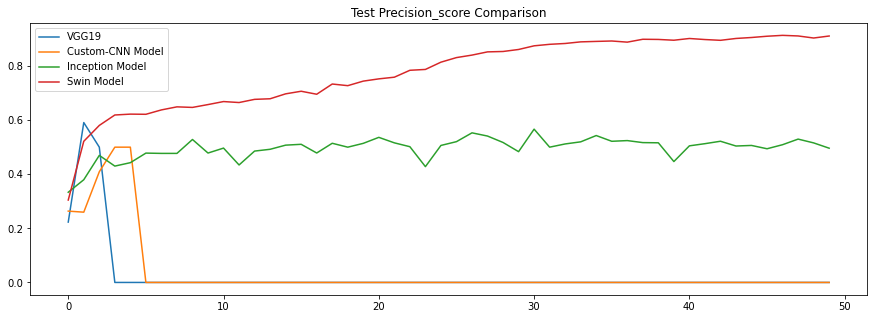

In [33]:
plt.figure(figsize=(15,5))
plt.title("Test Precision_score Comparison")
plt.plot(history_vgg.history["precision"],label="VGG19")
plt.plot(history_conv.history["precision_1"],label="Custom-CNN Model")
plt.plot(history_inception.history["precision_2"],label="Inception Model")
plt.plot(history_swin.history["precision_3"],label="Swin Model")
plt.legend()
plt.show()

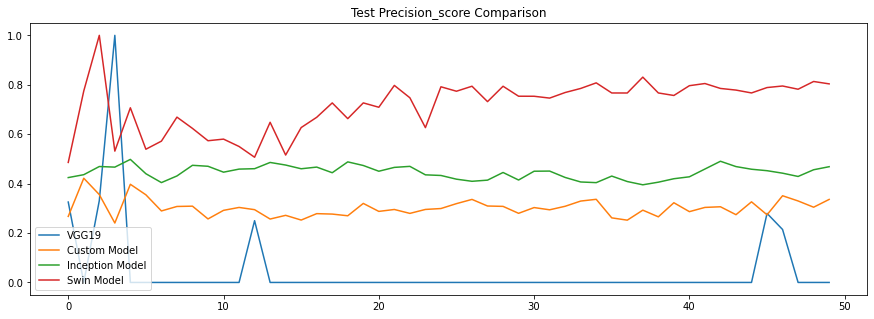

In [34]:
plt.figure(figsize=(15,5))
plt.title("Test Precision_score Comparison")
plt.plot(history_vgg.history["val_precision"],label="VGG19")
plt.plot(history_conv.history["val_precision_1"],label="Custom Model")
plt.plot(history_inception.history["val_precision_2"],label="Inception Model")
plt.plot(history_swin.history["val_precision_3"],label="Swin Model")
plt.legend()
plt.show()